# Customer Churn Prediction

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBRegressor
from pandas import to_datetime
import itertools
import warnings
import datetime
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score

In [2]:
df= pd.read_csv("churn raw data.csv")
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [4]:
exited = df['Exited'].value_counts(normalize = True)
exited*100

0    79.63
1    20.37
Name: Exited, dtype: float64

In [5]:
df["Gender"].value_counts()

Male      5457
Female    4543
Name: Gender, dtype: int64

In [6]:
df["NumOfProducts"].value_counts()

1    5084
2    4590
3     266
4      60
Name: NumOfProducts, dtype: int64

In [7]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [8]:
df_2 = df[['CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited']]

In [9]:
df_2

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


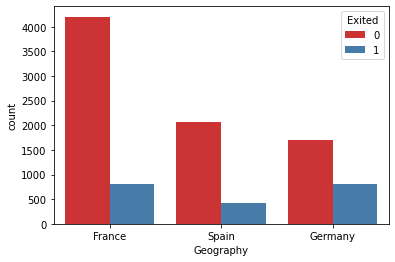

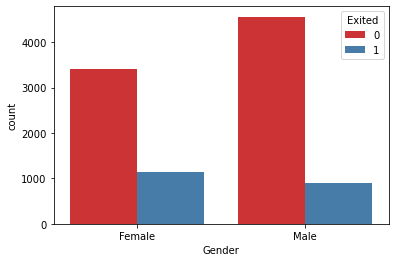

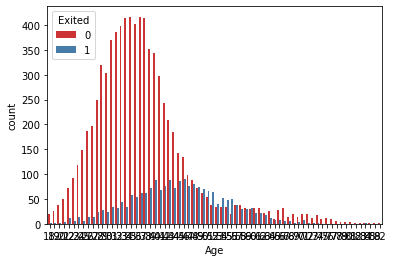

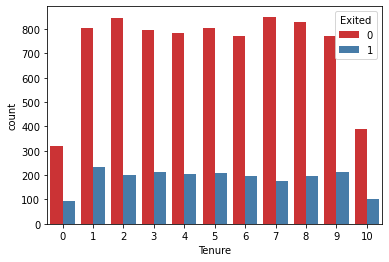

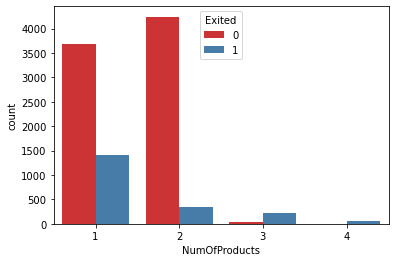

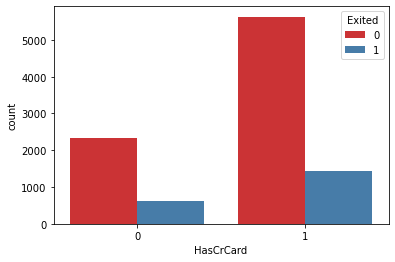

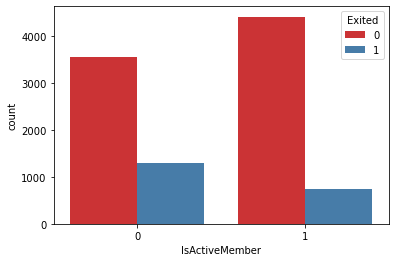

In [10]:
# Investigate all the features by our y

features = ['Geography', 'Gender', 'Age', 'Tenure', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember']


for f in features:
    plt.figure()
    ax = sns.countplot(x=f, data=df_2, hue = 'Exited', palette="Set1")

In [11]:
df_new = pd.get_dummies(df_2,columns=['Geography', 'Gender', 'HasCrCard', 'IsActiveMember'])
df_new

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,HasCrCard_0,HasCrCard_1,IsActiveMember_0,IsActiveMember_1
0,619,42,2,0.00,1,101348.88,1,1,0,0,1,0,0,1,0,1
1,608,41,1,83807.86,1,112542.58,0,0,0,1,1,0,1,0,0,1
2,502,42,8,159660.80,3,113931.57,1,1,0,0,1,0,0,1,1,0
3,699,39,1,0.00,2,93826.63,0,1,0,0,1,0,1,0,1,0
4,850,43,2,125510.82,1,79084.10,0,0,0,1,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5,0.00,2,96270.64,0,1,0,0,0,1,0,1,1,0
9996,516,35,10,57369.61,1,101699.77,0,1,0,0,0,1,0,1,0,1
9997,709,36,7,0.00,1,42085.58,1,1,0,0,1,0,1,0,0,1
9998,772,42,3,75075.31,2,92888.52,1,0,1,0,0,1,0,1,1,0


In [12]:
scale = ['CreditScore','EstimatedSalary','Balance','Age']
scaler = MinMaxScaler()
df_new[scale] = scaler.fit_transform(df_new[scale])
df_new.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,HasCrCard_0,HasCrCard_1,IsActiveMember_0,IsActiveMember_1
0,0.538,0.324324,2,0.000000,1,0.506735,1,1,0,0,1,0,0,1,0,1
1,0.516,0.310811,1,0.334031,1,0.562709,0,0,0,1,1,0,1,0,0,1
2,0.304,0.324324,8,0.636357,3,0.569654,1,1,0,0,1,0,0,1,1,0
3,0.698,0.283784,1,0.000000,2,0.469120,0,1,0,0,1,0,1,0,1,0
4,1.000,0.337838,2,0.500246,1,0.395400,0,0,0,1,1,0,0,1,0,1


In [13]:
X = df_new.drop('Exited', axis=1).values
y = df_new['Exited'].values 

In [14]:
X.shape

(10000, 15)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=  0.2, random_state=30)


print("X train:",X_train.shape)
print("X test:",X_test.shape)
print("y train:",y_train.shape)
print("y test:",y_test.shape)

X train: (8000, 15)
X test: (2000, 15)
y train: (8000,)
y test: (2000,)


# 1. Decision Tree

In [16]:
dt = DecisionTreeClassifier(criterion='entropy', max_depth=2, random_state=30)
dt.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=2, random_state=30)

In [17]:
# Accuracy on Train
print("Training Accuracy is: ", dt.score(X_train, y_train))

# Accuracy on Train
print("Testing Accuracy is: ", dt.score(X_test, y_test))


Training Accuracy is:  0.831
Testing Accuracy is:  0.823


In [18]:
# Confusion Matrix function

def plot_confusion_matrix(cm, classes=None, title='Confusion matrix'):
    """Plots a confusion matrix."""
    if classes is not None:
        sns.heatmap(cm, xticklabels=classes, yticklabels=classes, vmin=0., vmax=1., annot=True, annot_kws={'size':50})
    else:
        sns.heatmap(cm, vmin=0., vmax=1.)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

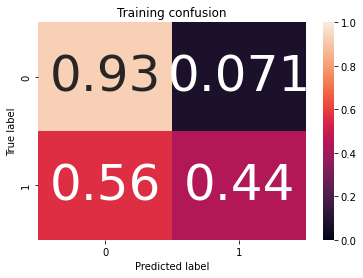

In [19]:
y_pred = dt.predict(X_train)

# Plotting Confusion Matrix
cm = confusion_matrix(y_train, y_pred)
cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_norm, classes=dt.classes_, title='Training confusion')

In [20]:
y_pred_train = dt.predict(X_train)
y_pred_train
confusion_matrix(y_train, y_pred)

array([[5946,  453],
       [ 899,  702]])

In [21]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = dt.predict(X_test)
y_pred
confusion_matrix(y_test, y_pred)

print("Classification Report : ", classification_report(y_test, y_pred))

Classification Report :                precision    recall  f1-score   support

           0       0.86      0.93      0.89      1564
           1       0.63      0.45      0.52       436

    accuracy                           0.82      2000
   macro avg       0.75      0.69      0.71      2000
weighted avg       0.81      0.82      0.81      2000



## 2. Random Forest

Training Accuracy is:  0.999875
Testing Accuracy is:  0.8625


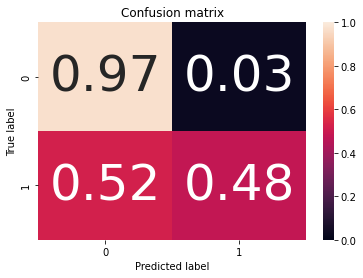

In [22]:
rf = RandomForestClassifier(n_estimators=100, criterion='entropy')
rf.fit(X_train, y_train)
prediction_test = rf.predict(X=X_test)

# source: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

# Accuracy on Test
print("Training Accuracy is: ", rf.score(X_train, y_train))
# Accuracy on Train
print("Testing Accuracy is: ", rf.score(X_test, y_test))

# Confusion Matrix
cm = confusion_matrix(y_test, prediction_test)
cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_norm, classes=rf.classes_)

In [23]:
y_pred = dt.predict(X_test)
y_pred
confusion_matrix(y_test, y_pred)

print("Classification Report : ", classification_report(y_test, y_pred))

Classification Report :                precision    recall  f1-score   support

           0       0.86      0.93      0.89      1564
           1       0.63      0.45      0.52       436

    accuracy                           0.82      2000
   macro avg       0.75      0.69      0.71      2000
weighted avg       0.81      0.82      0.81      2000



## 3.XGBoost

In [24]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost

classifier=xgboost.XGBClassifier(tree_method='gpu_hist')

params={
    "learning_rate":[0.05,0.10,0.15,0.20,0.25,0.30],
    "max_depth":[2,3,4,5,6,8,10,12,15],
    "min_child_weight":[1,3,5,7],
    "gamma":[0.0,0.1,0.2,0.3,0.4],
    "colsample_bytree":[0.3,0.4,0.5,0.7]}

clf =RandomizedSearchCV(classifier,param_distributions=params,n_iter=5,scoring='roc_auc',cv=5,verbose=2)

clf.fit(X,y)




Fitting 5 folds for each of 5 candidates, totalling 25 fits
[16:25:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.5, gamma=0.3, learning_rate=0.1, max_depth=2, min_child_weight=5; total time=   0.5s
[16:25:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.5, gamma=0.3, learning_rate=0.1, max_depth=2, min_child_weight=5; total time=   0.1s
[16:25:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric i

[CV] END colsample_bytree=0.4, gamma=0.3, learning_rate=0.05, max_depth=3, min_child_weight=7; total time=   0.1s
[16:25:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.4, gamma=0.3, learning_rate=0.05, max_depth=3, min_child_weight=7; total time=   0.1s
[16:25:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.4, gamma=0.3, learning_rate=0.05, max_depth=3, min_child_weight=7; total time=   0.1s
[16:25:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False, gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints...
                                           reg_alpha=None, reg_lambda=None,
                                           scale_pos_weight=None,
                                       

In [25]:
clf.best_params_

{'min_child_weight': 5,
 'max_depth': 6,
 'learning_rate': 0.05,
 'gamma': 0.3,
 'colsample_bytree': 0.4}

In [26]:
clf.best_score_

0.8632914189709883

In [27]:
clf.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4,
              enable_categorical=False, gamma=0.3, gpu_id=0,
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=6,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='gpu_hist',
              validate_parameters=1, verbosity=None)

In [28]:
model = xgboost.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5,
              enable_categorical=False, gamma=0.3, gpu_id=0,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=5, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='gpu_hist',
              validate_parameters=1, verbosity=None)

model.fit(X_train,y_train)


[16:25:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5,
              enable_categorical=False, gamma=0.3, gpu_id=0,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='gpu_hist',
              validate_parameters=1, verbosity=None)

In [29]:
pred_xgboost = model.predict(X_test)
pred_xgboost
confusion_matrix(y_test, pred_xgboost)

print("Classification Report : ", classification_report(y_test, pred_xgboost))

Classification Report :                precision    recall  f1-score   support

           0       0.87      0.98      0.92      1564
           1       0.84      0.47      0.61       436

    accuracy                           0.87      2000
   macro avg       0.86      0.72      0.76      2000
weighted avg       0.86      0.87      0.85      2000



# Using SMOTE and XGBoost

In [30]:
df_new

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,HasCrCard_0,HasCrCard_1,IsActiveMember_0,IsActiveMember_1
0,0.538,0.324324,2,0.000000,1,0.506735,1,1,0,0,1,0,0,1,0,1
1,0.516,0.310811,1,0.334031,1,0.562709,0,0,0,1,1,0,1,0,0,1
2,0.304,0.324324,8,0.636357,3,0.569654,1,1,0,0,1,0,0,1,1,0
3,0.698,0.283784,1,0.000000,2,0.469120,0,1,0,0,1,0,1,0,1,0
4,1.000,0.337838,2,0.500246,1,0.395400,0,0,0,1,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.842,0.283784,5,0.000000,2,0.481341,0,1,0,0,0,1,0,1,1,0
9996,0.332,0.229730,10,0.228657,1,0.508490,0,1,0,0,0,1,0,1,0,1
9997,0.718,0.243243,7,0.000000,1,0.210390,1,1,0,0,1,0,1,0,0,1
9998,0.844,0.324324,3,0.299226,2,0.464429,1,0,1,0,0,1,0,1,1,0


In [31]:
X_smote = df_new.drop('Exited', axis= 1)
y_smote = df_new.Exited


In [32]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy="minority") 
X_sm,y_sm = smote.fit_resample(X_smote,y_smote)

y_sm.value_counts()

1    7963
0    7963
Name: Exited, dtype: int64

In [33]:
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_sm,y_sm,test_size=0.2,random_state=30)

In [34]:
print("X train:",X_train_smote.shape)
print("X test:",X_test_smote.shape)
print("y train:",y_train_smote.shape)
print("y test:",y_test_smote.shape)

X train: (12740, 15)
X test: (3186, 15)
y train: (12740,)
y test: (3186,)


In [35]:
model_2 = xgboost.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5,
              enable_categorical=False, gamma=0.3, gpu_id=0,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=5, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='gpu_hist',
              validate_parameters=1, verbosity=None)

model_2.fit(X_train_smote,y_train_smote)

[16:25:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5,
              enable_categorical=False, gamma=0.3, gpu_id=0,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='gpu_hist',
              validate_parameters=1, verbosity=None)

In [36]:
pred_xgboost_2 = model_2.predict(X_test_smote)
pred_xgboost_2
confusion_matrix(y_test_smote, pred_xgboost_2)

print("Classification Report : ",classification_report(y_test_smote, pred_xgboost_2))

Classification Report :                precision    recall  f1-score   support

           0       0.85      0.88      0.86      1593
           1       0.87      0.84      0.86      1593

    accuracy                           0.86      3186
   macro avg       0.86      0.86      0.86      3186
weighted avg       0.86      0.86      0.86      3186



# On Unseen Data

In [37]:
unseen_df = pd.read_csv("new unseen data.csv")
unseen_df

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634638,AP Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647347,AP Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619340,AP Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701390,AP Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737924,AP Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3339,3340,15631341,AP Franklin,599,Spain,Female,28,4,126833.79,2,1,0,60843.09,1
3340,3341,15809299,AP Y?,729,Germany,Male,29,5,109676.52,1,1,1,25548.47,0
3341,3342,15640902,AP Peng,718,France,Female,29,3,0.00,1,0,1,134462.29,0
3342,3343,15775699,AP Otitodilichukwu,712,Germany,Male,53,6,134729.99,2,1,1,132702.64,0


In [38]:
unseen_df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [39]:
#Applying the same

# Limiting the data
unseen_df_2 = unseen_df[['CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary']]

unseen_df_2 = pd.get_dummies(unseen_df_2, columns = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember'])


scale_vars = ['CreditScore','EstimatedSalary','Balance','Age']
unseen_df_2[scale_vars] = scaler.fit_transform(unseen_df_2[scale_vars])


unseen_df_2.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,HasCrCard_0,HasCrCard_1,IsActiveMember_0,IsActiveMember_1
0,0.538,0.342857,2,0.000000,1,0.507077,1,0,0,1,0,0,1,0,1
1,0.516,0.328571,1,0.334031,1,0.563089,0,0,1,1,0,1,0,0,1
2,0.304,0.342857,8,0.636357,3,0.570039,1,0,0,1,0,0,1,1,0
3,0.698,0.300000,1,0.000000,2,0.469437,1,0,0,1,0,1,0,1,0
4,1.000,0.357143,2,0.500246,1,0.395667,0,0,1,1,0,0,1,0,1


In [43]:
pred_xgboost = model_2.predict(unseen_df_2.values)
pred_prob_xgboost = model_2.predict_proba(unseen_df_2.values)

pred_xgboost

array([1, 1, 1, ..., 0, 1, 1])

In [44]:
# function to select second column for probabilities
def column(matrix, i):
    return [row[i] for row in matrix]

column(pred_prob_xgboost, 1)

[0.79063326,
 0.7436644,
 0.9855239,
 0.43940505,
 0.5509183,
 0.7772529,
 0.11011421,
 0.9779548,
 0.58308196,
 0.1303902,
 0.24555883,
 0.03317238,
 0.15897816,
 0.04564485,
 0.16719604,
 0.5139456,
 0.9359125,
 0.032599136,
 0.87301105,
 0.04489547,
 0.16084823,
 0.33889398,
 0.83438945,
 0.2472853,
 0.5425068,
 0.02541935,
 0.7670069,
 0.40466884,
 0.88642454,
 0.2952535,
 0.9662578,
 0.5942462,
 0.7487853,
 0.2934235,
 0.07770164,
 0.8826205,
 0.2936431,
 0.326786,
 0.52192336,
 0.4379099,
 0.88516986,
 0.9111656,
 0.4128813,
 0.8221402,
 0.33513555,
 0.50782484,
 0.3363705,
 0.8226412,
 0.8210067,
 0.2852423,
 0.70202315,
 0.62131464,
 0.15697947,
 0.92057896,
 0.91183525,
 0.7149747,
 0.8353242,
 0.31735653,
 0.73411196,
 0.87456125,
 0.8012192,
 0.20562689,
 0.37279525,
 0.4107506,
 0.2970814,
 0.41777223,
 0.7725918,
 0.35482028,
 0.44788346,
 0.23171608,
 0.9944283,
 0.41766268,
 0.59494406,
 0.100156255,
 0.1555915,
 0.13215701,
 0.13209106,
 0.6900148,
 0.25772098,
 0.76785

In [46]:
# 9.4. Joining the raw data witht the predictions

output = unseen_df.copy()
output['Predictions - Churn or Not'] = pred_xgboost
output['Predictions - Probability to Churn'] = column(pred_prob_xgboost, 1)
output['Predictions - Churn or Not Desc'] = 'Empty'
output['Predictions - Churn or Not Desc'][output['Predictions - Churn or Not'] == 0] = 'Retention'
output['Predictions - Churn or Not Desc'][output['Predictions - Churn or Not'] == 1] = 'Churn'
output.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Predictions - Churn or Not,Predictions - Probability to Churn,Predictions - Churn or Not Desc
0,1,15634638,AP Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,0.790633,Churn
1,2,15647347,AP Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,0.743664,Churn
2,3,15619340,AP Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,0.985524,Churn
3,4,15701390,AP Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,0.439405,Retention
4,5,15737924,AP Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,1,0.550918,Churn


In [48]:
output.to_csv('Churn Predictions Output.csv', sep='\t')
